#       Name: Gitesh Garg
#       Roll number: 101903031
#       Batch: 4CO2

## Description: We use Light Gradient Boosting Machine for solving the time series prediction problem of Road sensor dataset

## Step 1: PREPROCESSING

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read and print the excel file
import pandas as pd
df = pd.read_excel('DATASET.xlsx')
df.head()

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


In [3]:
# Remove anomolies of sections
clear_idx = 910
lst_to_clear = []
for i in range(9):
    lst_to_clear.append(clear_idx+i)
lst_to_clear
df.fillna(0, inplace=True)
df.drop(lst_to_clear, inplace = True)

In [4]:
# Rename column to section_name
df.columns = df.columns.str.replace('Unnamed: 0', 'Section_name')

In [5]:
# Naming sections 
mul = 10
j = 0
for i in range(100):
    sec_name = df.iloc[j,0]
    df.iloc[j:j + mul, 0] = sec_name
    j += mul
test_frame = df.loc[df['year'] == 10]
df.head()

,Section_name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


## Step 2: TRAINING AND TESTING

In [6]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=19)

In [7]:
# Extract the training part of input dataset
move = 9
def extract_xtrain(df, row_start, col_start):
    row_end = row_start + move
    return df.iloc[row_start:row_end, 1:10]

In [8]:
# Extract the training part of output dataset
def extract_ytrain(df, row_start, col_start):
    row_end = row_start + move
    return df.iloc[row_start:row_end, col_start]

In [9]:
# Extract the testing part of input dataset
def extract_xtest(df, row_start):
    row_end = row_start + move
    return df.iloc[row_end, 1:10].to_numpy()

In [10]:
# Extract the output part of ouput dataset
def extract_ytest(df, row_start, col_start):
    row_end = row_start + move
    return df.iloc[row_end, col_start]

In [11]:
# function to calcuate mean square error
def calcuate_lmse(predict_val, test_val):
    pred_diff = predict_val - test_val
    return (pred_diff)**2

In [12]:
# Get the XY Split
column_name = ["Para-"+str(i) for i in range(9,14)]
XY = []
def getXYsplit(df, row_start, row_end):
    XY = []
    XY.append(extract_xtrain(df, row_start, row_end))
    XY.append(extract_ytrain(df, row_start, row_end))
    XY.append(extract_xtest(df,row_start))
    XY.append(extract_ytest(df,row_start,row_end))
    return XY

In [13]:
from collections import defaultdict

In [14]:
# Create a dictionary for storing predicted and true values
pred_values = defaultdict(lambda : [])

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
target_col = [10,11,12,13,14]
root_mean_square_error = []
total_count = 0
curr_section = 0
total_squared_error = 0
max_val = 1000
for j in target_col:
    local_squared_error = 0
    l_count = 0
    LXY = [0,0,0,0]
    for i in range(0, max_val, 10):
        LXY = getXYsplit(df,i,j)
        x_train, y_train,x_test,y_test = LXY[0],LXY[1],LXY[2],LXY[3]

        # fit the model and predict
        model.fit(x_train, y_train)
        ypred = model.predict(x_test.reshape(1,-1))[0]

        # store the predicted values
        pred_values[column_name[curr_section]].append(ypred)
    
        # store squared difference for RMSE

        # local_squared_error = calcuate_lmse(ypred, y_test) + local_squared_error
        total_squared_error = calcuate_lmse(ypred, y_test) + total_squared_error
        l_count += 1
        total_count += 1

    # root_mean_square_error.append(local_squared_error)
    curr_section += 1
predicted_df = pd.DataFrame.from_dict(pred_values)

In [17]:
# Calculate  RMSE
total_rmse_by_n = total_squared_error/total_count
final_rmse = total_rmse_by_n**0.5

print("The RMSE is " + str(final_rmse))

The RMSE is 68.76256275509705


## Step 3: PLOTTING

In [18]:
# Get random rows for plotting
import random
plot_row = 99

random_rows = []
for i in range(plot_row):
    random_rows.append(i+1)

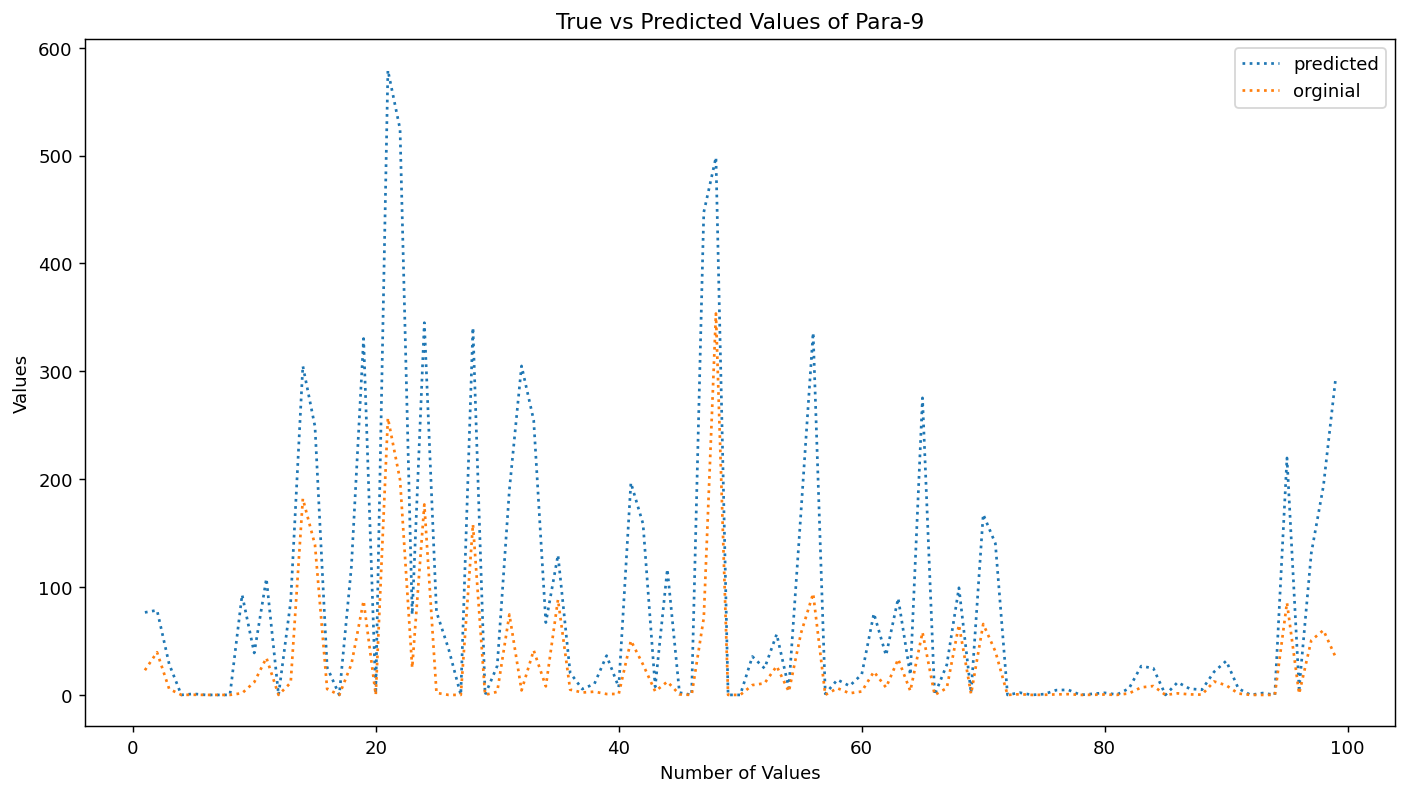

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,10]
x_value = []
for i in range(len(true_value)):
    x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')
plt.savefig('True vs Predicted Values of Para-9.png')

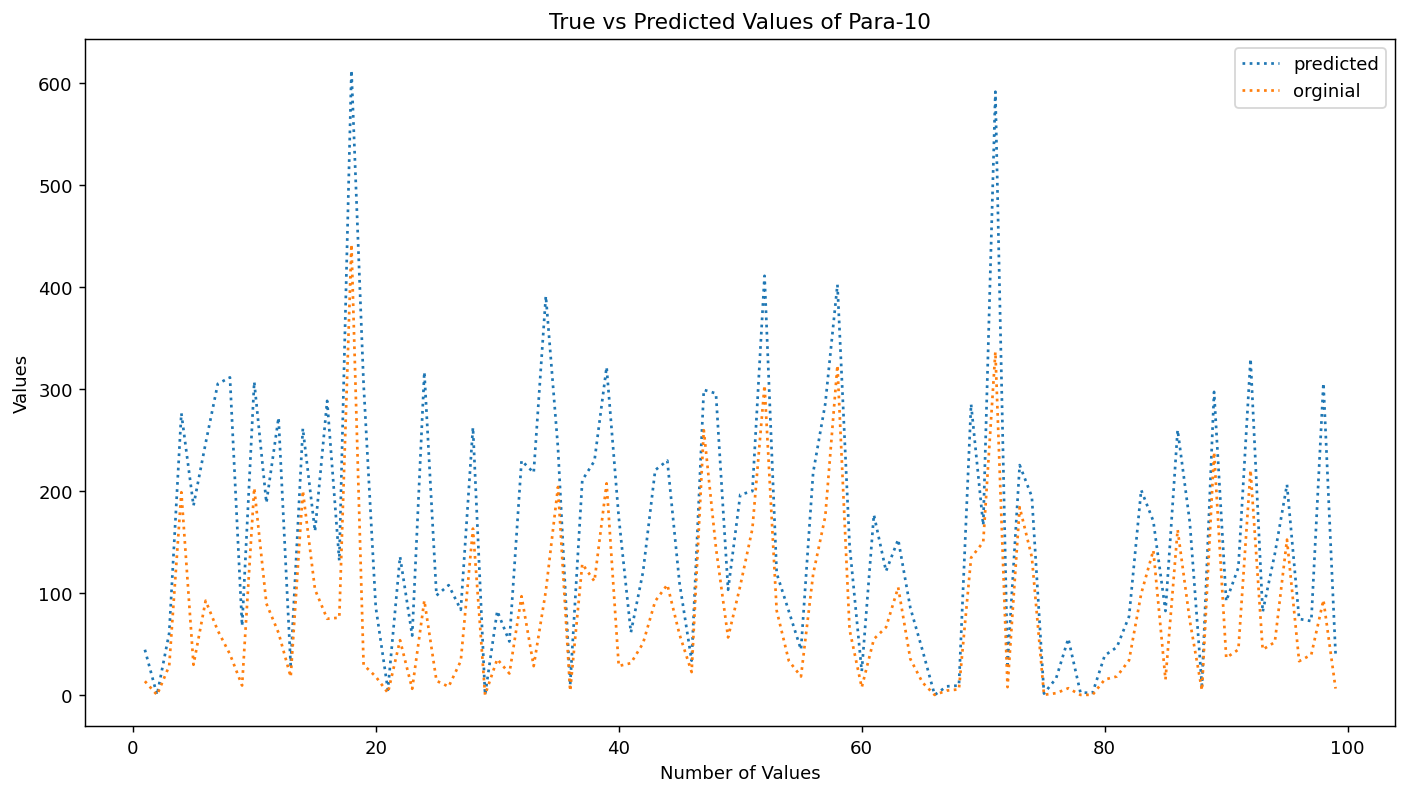

In [20]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 1]
predicted_value = test_frame.iloc[random_rows,11]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-10')
plt.legend(loc = 'upper right')
plt.savefig('True vs Predicted Values of Para-10.png')

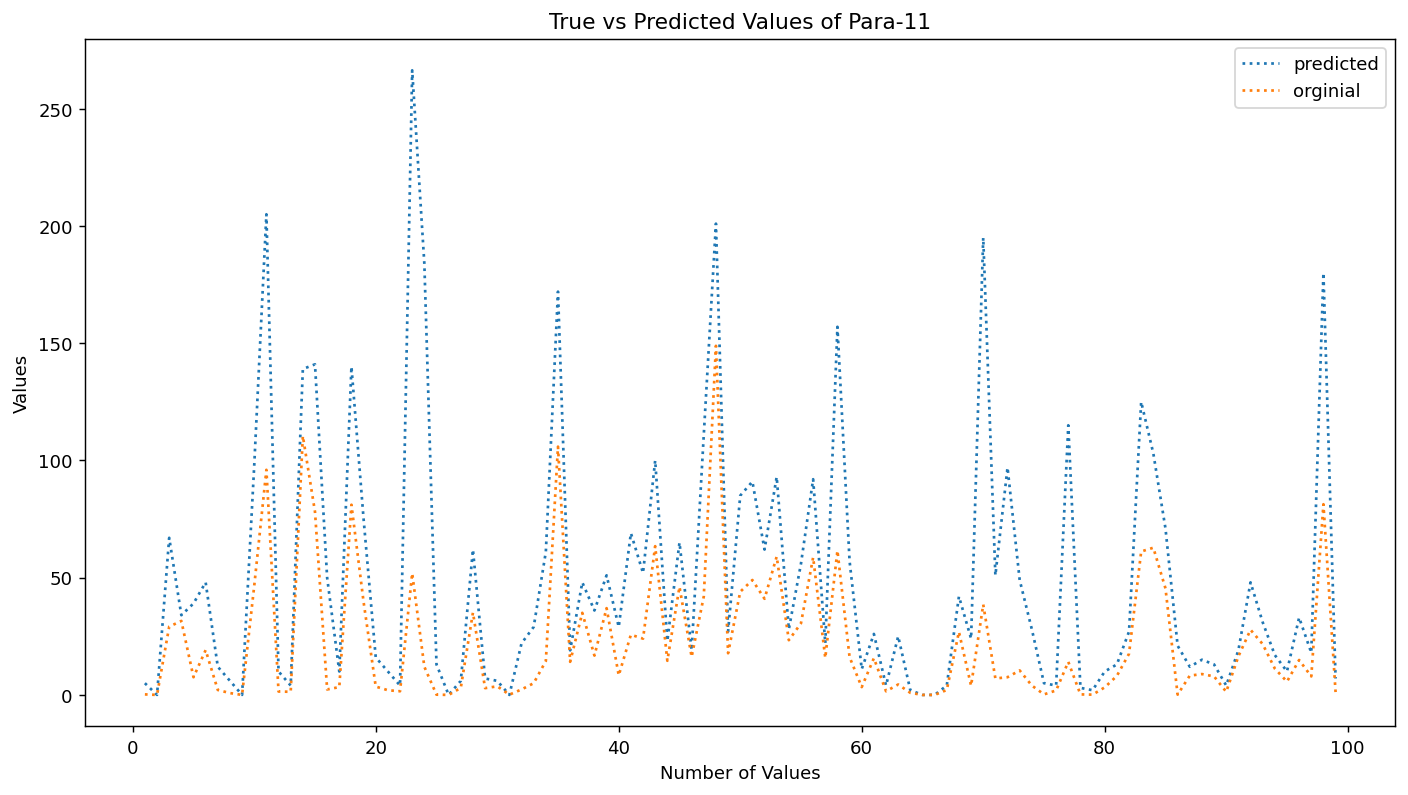

In [21]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 2]
predicted_value = test_frame.iloc[random_rows,12]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-11')
plt.legend(loc = 'upper right')
plt.savefig('True vs Predicted Values of Para-11.png')

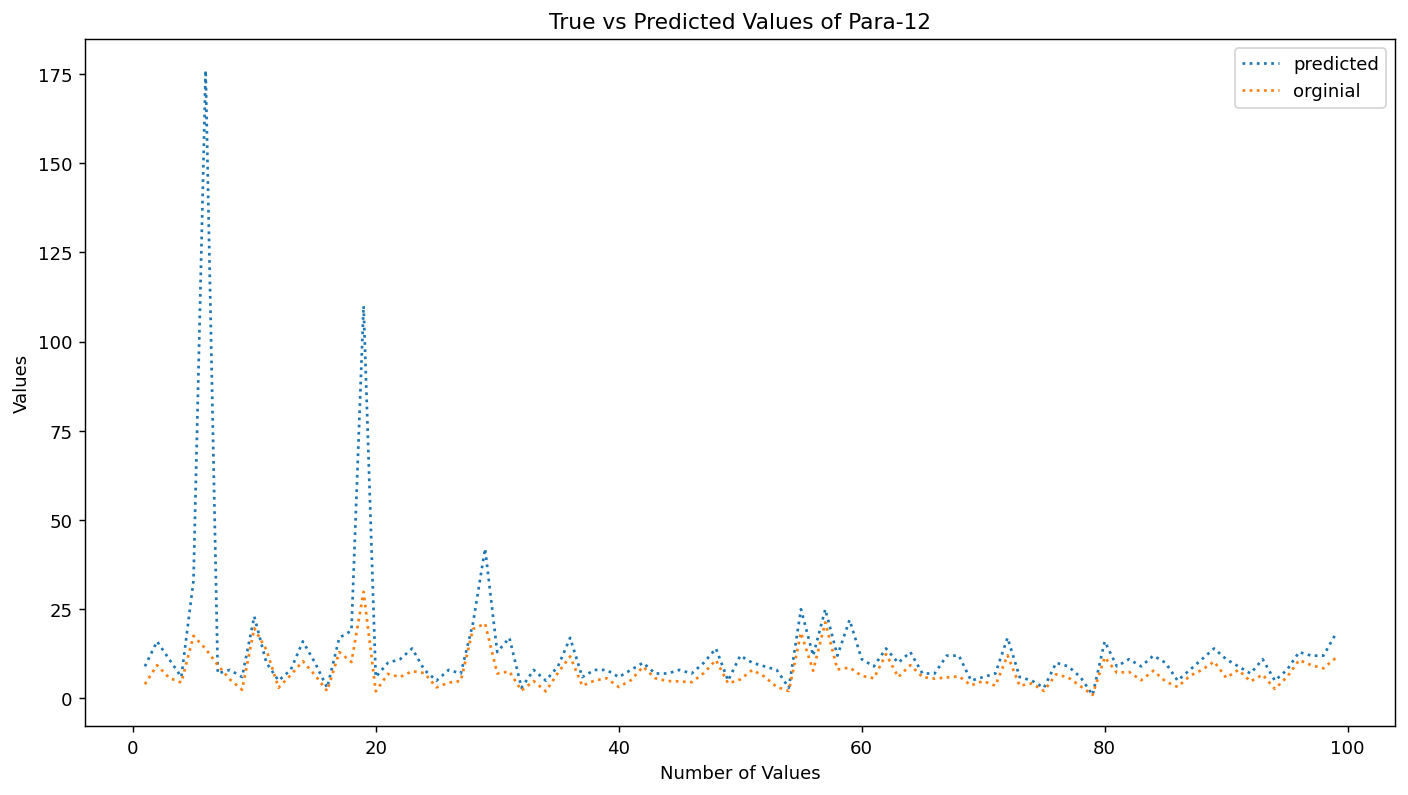

In [22]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 3]
predicted_value = test_frame.iloc[random_rows,13]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-12')
plt.legend(loc = 'upper right')
plt.savefig('True vs Predicted Values of Para-12.png')

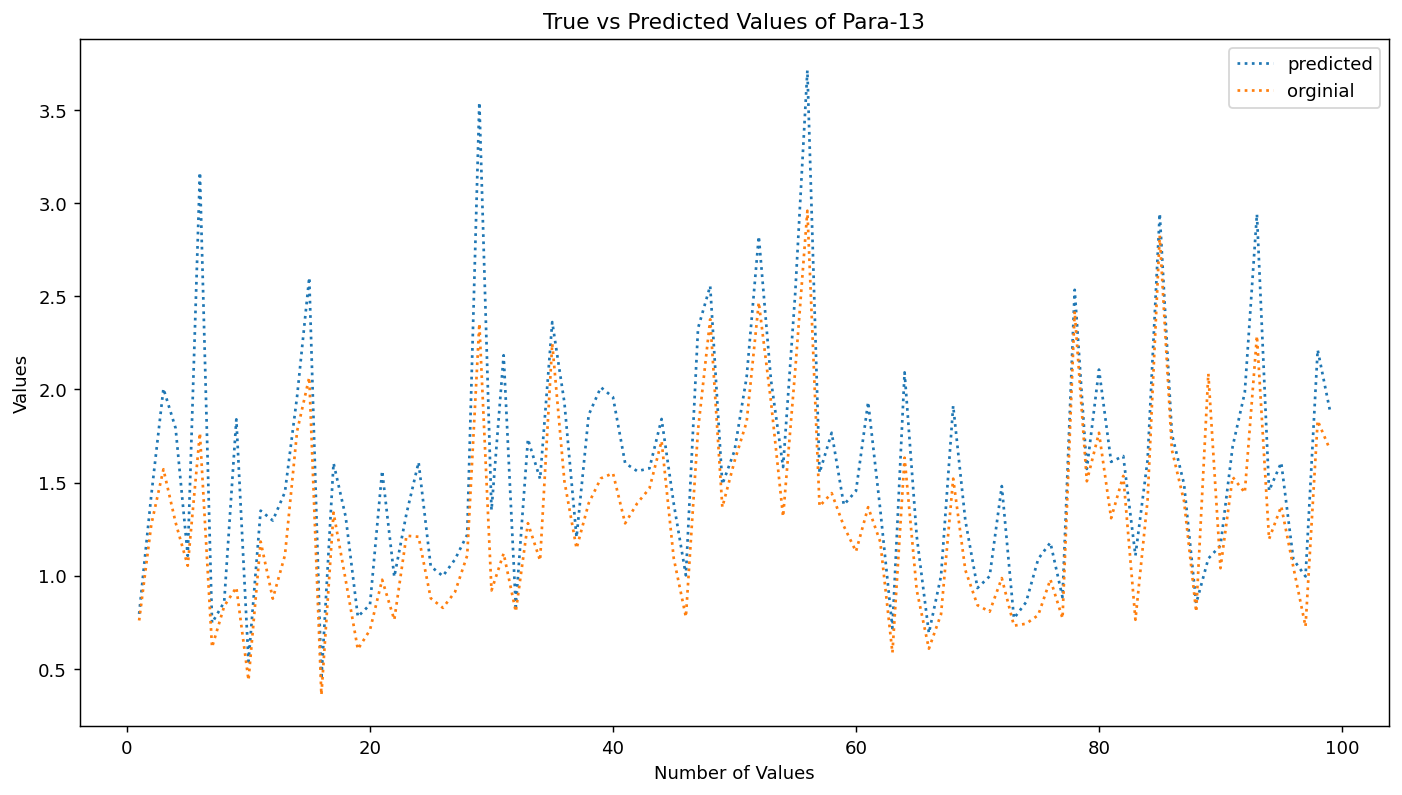

In [23]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 4]
predicted_value = test_frame.iloc[random_rows,14]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-13')
plt.legend(loc = 'upper right')
plt.savefig('True vs Predicted Values of Para-13.png')